# データの前処理

In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/インテグ/telecom_customer_churn 3.csv')

df_zipcode = pd.read_csv('/content/drive/MyDrive/インテグ/telecom_zipcode_population.csv')

In [ ]:
# 両方のデータフレームに 'Zip Code' という列があると仮定して、左結合を行います
merged_df = df.merge(df_zipcode, on='Zip Code', how='left')


In [ ]:
zip_codes = merged_df['Zip Code'].astype(str).unique().tolist()


In [ ]:
!pip install requests pandas
import requests

In [ ]:
#US Breau のAPIより人口統計データをDL
import requests
import pandas as pd
# APIキーを入力
API_KEY = ''


# 取得するデータの変数
variables = [
    'NAME',
    'B01003_001E',  # 総人口
    'B19013_001E',  # 世帯収入の中央値
    'B23025_002E',  # 労働力人口
    'B25077_001E',  # 住宅の中央値
    'B15003_001E'   # 教育水準
]
# データを格納するリスト
data = []
# 各ZIPコードに対してデータを取得
for zip_code in zip_codes:
    url = f'https://api.census.gov/data/2022/acs/acs5'
    params = {
        'get': ','.join(variables),
        'for': f'zip code tabulation area:{zip_code}',
        'key': API_KEY
    }
    response = requests.get(url, params=params)
    # ステータスコードを確認
    if response.status_code != 200:
        print("Error: Received status code {response.status_code} for ZIP code {zip_code}")
        continue
    try:
        # レスポンスの内容をJSONとして解析
        response_data = response.json()
        data.extend(response_data[1:])  # 最初の行はヘッダーなのでスキップ
    except requests.exceptions.JSONDecodeError:
        print(f"Error: Could not decode JSON for ZIP code {zip_code})")
        print(f"Response content: {response.text}")
# データフレームに変換
columns = ['NAME', 'population', 'median_household_income', 'labor_force', 'median_home_value', 'education_level', 'Zip Code']
df_census = pd.DataFrame(data, columns=columns)
# データフレームを表示
print(df_census)


Error: Received status code {response.status_code} for ZIP code {zip_code}
             NAME population median_household_income labor_force  \
0     ZCTA5 93225       5018                   46923        2466   
1     ZCTA5 91206      32294                   85651       16818   
2     ZCTA5 92627      62181                  105647       37568   
3     ZCTA5 94553      49062                  118704       27230   
4     ZCTA5 93010      47656                  104847       23945   
...           ...        ...                     ...         ...   
1620  ZCTA5 93908      12983                  159688        6239   
1621  ZCTA5 96150      29457                   76980       17345   
1622  ZCTA5 91934       1251              -666666666         608   
1623  ZCTA5 93013      16459                  115000        8723   
1624  ZCTA5 95956        458                   61182         153   

     median_home_value education_level Zip Code  
0               282100            3573    93225  
1       

In [ ]:
# 'Zip Code' 列を文字列型に変換
merged_df['Zip Code'] = merged_df['Zip Code'].astype(str)

# 結合を再試行
merged_df_us = pd.merge(merged_df, df_census, left_on='Zip Code', right_on='Zip_Code_Extracted', how='left')

# CSVファイルとして書き出し
merged_df_us.to_csv('merged_df_us.csv', index=False)



# EDA

In [ ]:
# 1. 欠損値の確認
merged_df.isnull().sum()

# offer → offerがない人は空白
# Avg Long & Multiple Line → Phoneサービスに申し込んでない人は空白
# Internet type ~ Unlimited data → internetサービスに申し込んでない人は空白
# churn category & reason → Stayedとjoinedの人は、空白。
#　　偏りがあるデータであることが確認できる。


Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

# 機械学習用のデータへ加工。

In [ ]:
# yes/noのデータを1/0に変換
columns_to_convert = ['Married', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing']

merged_df[columns_to_convert] = merged_df[columns_to_convert].applymap(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else x))

In [ ]:
# Churn CategoryとChurn Reason,offerを除くすべての列のnull値を0に置き換え
cols_to_exclude = ['Churn Category', 'Churn Reason']
merged_df = merged_df.apply(lambda x: x.fillna(0) if x.name not in cols_to_exclude else x)

In [ ]:
merged_df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Internet Type                           0
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection Plan                  0
Premium Tech Support                    0
Streaming TV                            0
Streaming Movies                  

In [ ]:
# Customer Statusの変換
merged_df = merged_df[merged_df['Customer Status'] != 'Joined']
merged_df['Customer Status'] = merged_df['Customer Status'].map({'Stayed': 0, 'Churned': 1})

# 指定された特徴量を除外
features_to_exclude = [
    'Customer ID', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Churn Category', 'Churn Reason'
]
merged_df = merged_df.drop(columns=features_to_exclude)

# カテゴリ変数をダミー変数に変換
merged_df = pd.get_dummies(merged_df,drop_first=True)

# 結果を表示


<ipython-input-9-92bdfb250b5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Customer Status'] = merged_df['Customer Status'].map({'Stayed': 0, 'Churned': 1})


In [ ]:
# 数値データのみを標準化
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
# ダミー変数以外の数値データの列名をリストアップ
non_dummy_columns = [col for col in merged_df.columns if len(merged_df[col].unique()) > 2 and merged_df[col].dtype in ['int64', 'float64']]
merged_df[non_dummy_columns] = scaler.fit_transform(merged_df[non_dummy_columns])

# 結果を表示
print(merged_df)

           Age  Married  Number of Dependents  Number of Referrals  \
0    -0.579600        1             -0.491619            -0.006926   
1    -0.045161        0             -0.491619            -0.668349   
2     0.192368        0             -0.491619            -0.668349   
3     1.855067        1             -0.491619            -0.337638   
4     1.676921        1             -0.491619             0.323785   
...        ...      ...                   ...                  ...   
7037 -0.638982        0             -0.491619            -0.668349   
7038 -1.589096        0             -0.491619            -0.668349   
7039 -0.401453        1             -0.491619            -0.337638   
7041 -1.529714        1             -0.491619             0.985207   
7042 -0.638982        1             -0.491619            -0.337638   

      Tenure in Months  Phone Service  Avg Monthly Long Distance Charges  \
0            -1.063957              1                           1.253468   
1      

In [ ]:
merged_df.groupby('Customer Status').size()

Customer Status
0    4720
1    1869
dtype: int64

In [ ]:
#オーバーサンプリングを実施

!pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import SMOTE

# 特徴量とラベルを分ける
X = merged_df.drop('Customer Status', axis=1)
y = merged_df['Customer Status']

# SMOTEを使用してオーバーサンプリング
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# オーバーサンプリング後のデータフレームを作成
oversampled_df = pd.DataFrame(X_resampled, columns=X.columns)
oversampled_df['Customer Status'] = y_resampled

# 結果の行数を表示
print(oversampled_df['Customer Status'].value_counts())

Customer Status
0    4720
1    4720
Name: count, dtype: int64


# モデルを作成し、評価

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# ここでは既に存在するmerged_dfとoversampled_dfを使用します

# 特徴量とラベルを分ける
X_merged = merged_df.drop('Customer Status', axis=1)
y_merged = merged_df['Customer Status']

X_over = oversampled_df.drop('Customer Status', axis=1)
y_over = oversampled_df['Customer Status']

# データの分割
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# モデルのリスト
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "LightGBM": lgb.LGBMClassifier()
}

# 結果を格納するための辞書
results = {
    "merged_df": {},
    "oversampled_df": {}
}

# モデルの学習と評価
for name, model in models.items():
    # merged_dfでのモデル
    model.fit(X_train_merged, y_train_merged)
    y_pred_proba_merged = model.predict_proba(X_test_merged)[:, 1]
    auc_merged = roc_auc_score(y_test_merged, y_pred_proba_merged)
    results["merged_df"][name] = auc_merged

    # oversampled_dfでのモデル
    model.fit(X_train_over, y_train_over)
    y_pred_proba_over = model.predict_proba(X_test_over)[:, 1]
    auc_over = roc_auc_score(y_test_over, y_pred_proba_over)
    results["oversampled_df"][name] = auc_over

# 結果の表示
for df_name, result in results.items():
    print(f"Results for {df_name}:")
    for model_name, auc in result.items():
        print(f"{model_name}: ROC-AUC = {auc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1486, number of negative: 3785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 5271, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281920 -> initscore=-0.934958
[LightGBM] [Info] Start training from score -0.934958
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3786, number of negative: 3766
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 特徴量とラベルを分ける
X_merged = merged_df.drop('Customer Status', axis=1)
y_merged = merged_df['Customer Status']

X_over = oversampled_df.drop('Customer Status', axis=1)
y_over = oversampled_df['Customer Status']

# データの分割
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# モデルのリスト
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "LightGBM": lgb.LGBMClassifier()
}

# 結果を格納するための辞書
results = {
    "merged_df": {},
    "oversampled_df": {}
}

# モデルの学習と評価
for name, model in models.items():
    # merged_dfでのモデル
    model.fit(X_train_merged, y_train_merged)
    y_pred_proba_merged = model.predict_proba(X_test_merged)[:, 1]
    auc_merged = roc_auc_score(y_test_merged, y_pred_proba_merged)
    results["merged_df"][name] = auc_merged

    # oversampled_dfでのモデル
    model.fit(X_train_over, y_train_over)
    y_pred_proba_over = model.predict_proba(X_test_over)[:, 1]
    auc_over = roc_auc_score(y_test_over, y_pred_proba_over)
    results["oversampled_df"][name] = auc_over

    # クロスバリデーションスコアの計算
    cv_scores_merged = cross_val_score(model, X_merged, y_merged, cv=5, scoring='roc_auc')
    cv_scores_over = cross_val_score(model, X_over, y_over, cv=5, scoring='roc_auc')

    print(f"Cross-validation scores for {name} on merged_df: {cv_scores_merged}")
    print(f"Average CV score for {name} on merged_df: {cv_scores_merged.mean():.4f}")

    print(f"Cross-validation scores for {name} on oversampled_df: {cv_scores_over}")
    print(f"Average CV score for {name} on oversampled_df: {cv_scores_over.mean():.4f}")

# 結果の表示
for df_name, result in results.items():
    print(f"Results for {df_name}:")
    for model_name, auc in result.items():
        print(f"{model_name}: ROC-AUC = {auc:.4f}")

Cross-validation scores for Logistic Regression on merged_df: [0.91263426 0.91139932 0.91241333 0.90989815 0.92503522]
Average CV score for Logistic Regression on merged_df: 0.9143
Cross-validation scores for Logistic Regression on oversampled_df: [0.90676507 0.91192702 0.92712336 0.92514162 0.94045914]
Average CV score for Logistic Regression on oversampled_df: 0.9223
Cross-validation scores for Random Forest on merged_df: [0.92174613 0.91352788 0.91973653 0.92743927 0.93247887]
Average CV score for Random Forest on merged_df: 0.9230
Cross-validation scores for Random Forest on oversampled_df: [0.94483334 0.95027695 0.98706875 0.98543264 0.98625799]
Average CV score for Random Forest on oversampled_df: 0.9708
Cross-validation scores for SVM on merged_df: [0.9032703  0.90802309 0.91188933 0.90675417 0.92453254]
Average CV score for SVM on merged_df: 0.9109
Cross-validation scores for SVM on oversampled_df: [0.92109959 0.92211851 0.94527659 0.94626634 0.9529376 ]
Average CV score for SV

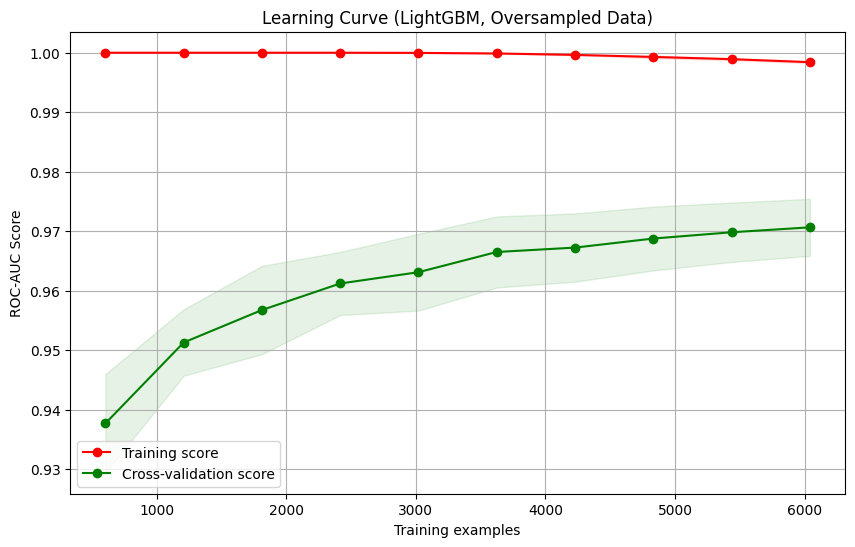

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 特徴量とラベルを分ける
X_over = oversampled_df.drop('Customer Status', axis=1)
y_over = oversampled_df['Customer Status']

# データの分割
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# LightGBMモデルの定義
model = lgb.LGBMClassifier()

# 学習曲線の計算
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train_over, y_train_over, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# 学習曲線の平均と標準偏差を計算
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.title("Learning Curve (LightGBM, Oversampled Data)")
plt.xlabel("Training examples")
plt.ylabel("ROC-AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# light gbmを使い、過学習に配慮し、モデルを作成する

In [ ]:
from sklearn.model_selection import train_test_split

# 特徴量とラベルを分ける
X = oversampled_df.drop('Customer Status', axis=1)
y = oversampled_df['Customer Status']

# データをtrain、validation、testに分割
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Train set size: 6608
Validation set size: 1416
Test set size: 1416


In [ ]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# # LightGBMモデル
# model = lgb.LGBMClassifier()

# # ハイパーパラメータグリッド
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 500]
# }

# # グリッドサーチ
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # 最適なパラメータ
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_}")

# # 最適なパラメータでモデルをトレーニング
# best_model = grid_search.best_estimator_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3313, number of negative: 3295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4647
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501362 -> initscore=0.005448
[LightGBM] [Info] Start training from score 0.005448
Best parameters found: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 70}
Best cross-validation score: 0.9708206845400621


In [ ]:
# 最適なモデルでトレーニング
best_model.fit(X_train, y_train)

# 検証データでの評価
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
val_auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC-AUC score: {val_auc_score:.4f}")

# テストデータでの評価
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_auc_score = roc_auc_score(y_test, y_test_pred_proba)
print(f"Test ROC-AUC score: {test_auc_score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3313, number of negative: 3295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4647
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501362 -> initscore=0.005448
[LightGBM] [Info] Start training from score 0.005448
Validation ROC-AUC score: 0.9769
Test ROC-AUC score: 0.9736


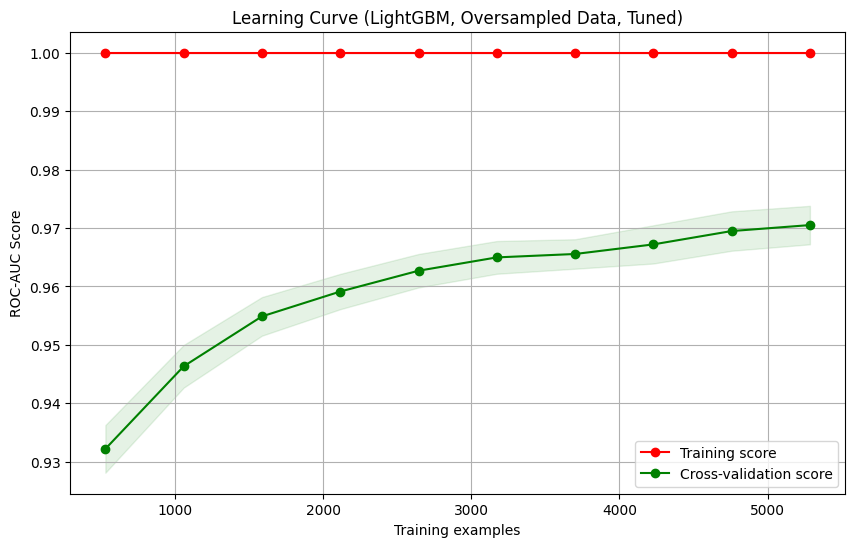

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 学習曲線の計算
train_sizes, train_scores, valid_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# 学習曲線の平均と標準偏差を計算
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.title("Learning Curve (LightGBM, Oversampled Data, Tuned)")
plt.xlabel("Training examples")
plt.ylabel("ROC-AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [ ]:
##最終的なスコアをまとめると
#Best parameters found: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 70}
#Best cross-validation score: 0.9708206845400621

#Validation ROC-AUC score: 0.9769
#Test ROC-AUC score: 0.9736

In [ ]:
# #モデルのトレーニングに時間がかかるので、保存。


# import joblib


# # 既にトレーニング済みのモデルオブジェクト `best_model` が存在する前提
# # モデルをGoogleドライブの指定したディレクトリに保存する
# model_filename = '/content/drive/MyDrive/インテグ/best_lightgbm_model.joblib'
# joblib.dump(best_model, model_filename)


['/content/drive/MyDrive/インテグ/best_lightgbm_model.joblib']

In [ ]:
#モデルを呼び起こす
import joblib

model_filename = '/content/drive/MyDrive/インテグ/best_lightgbm_model.joblib'

# モデルを読み込む
best_model = joblib.load(model_filename)
print("Model loaded successfully")


Model loaded successfully


In [ ]:
import joblib
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score

# モデルの予測
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 混同行列
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# F値
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

# 検出力（リコール）
recall = recall_score(y_test, y_test_pred)
print(f"Recall: {recall:.4f}")

# 正解率
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

# 精度（プレシジョン）
precision = precision_score(y_test, y_test_pred)
print(f"Precision: {precision:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 詳細な分類レポート
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[658  62]
 [ 69 627]]
F1 Score: 0.9054
Recall: 0.9009
Accuracy: 0.9075
Precision: 0.9100
ROC-AUC Score: 0.9736
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       720
           1       0.91      0.90      0.91       696

    accuracy                           0.91      1416
   macro avg       0.91      0.91      0.91      1416
weighted avg       0.91      0.91      0.91      1416



In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


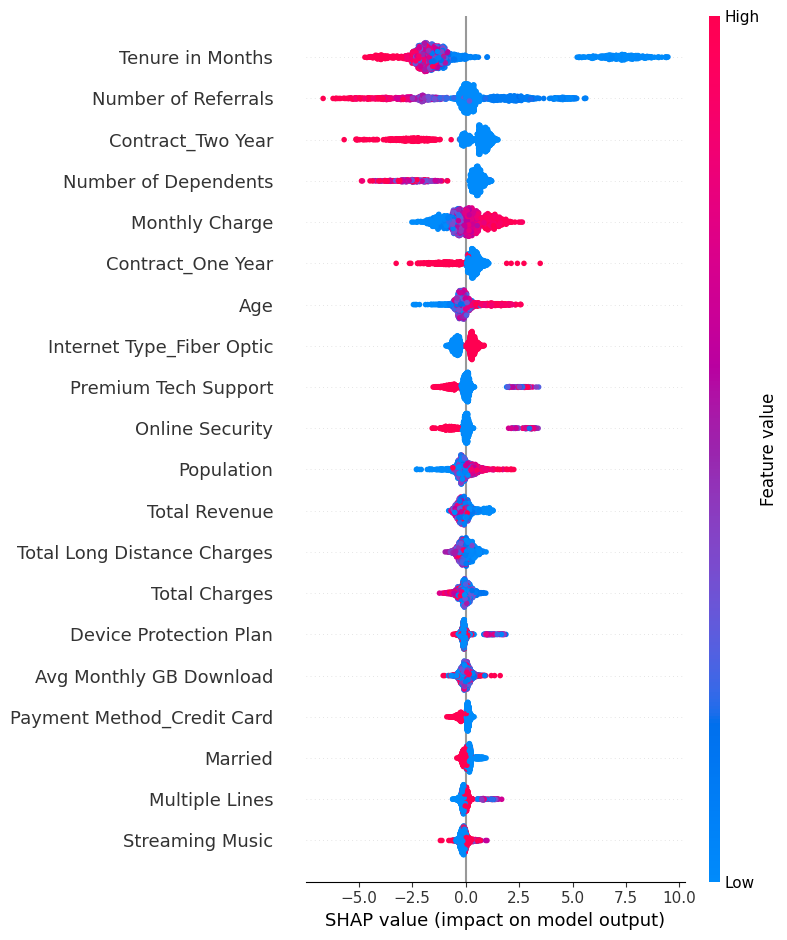

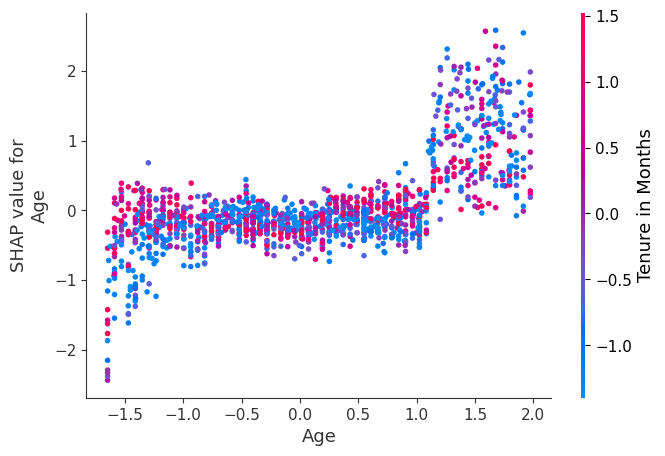

In [ ]:
# SHAP explainerの作成
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

# SHAP dependence plot for a specific feature (for example, 'Age')
shap.dependence_plot("Age", shap_values, X_test)  # shap_valuesはクラス全体のSHAP値を示す

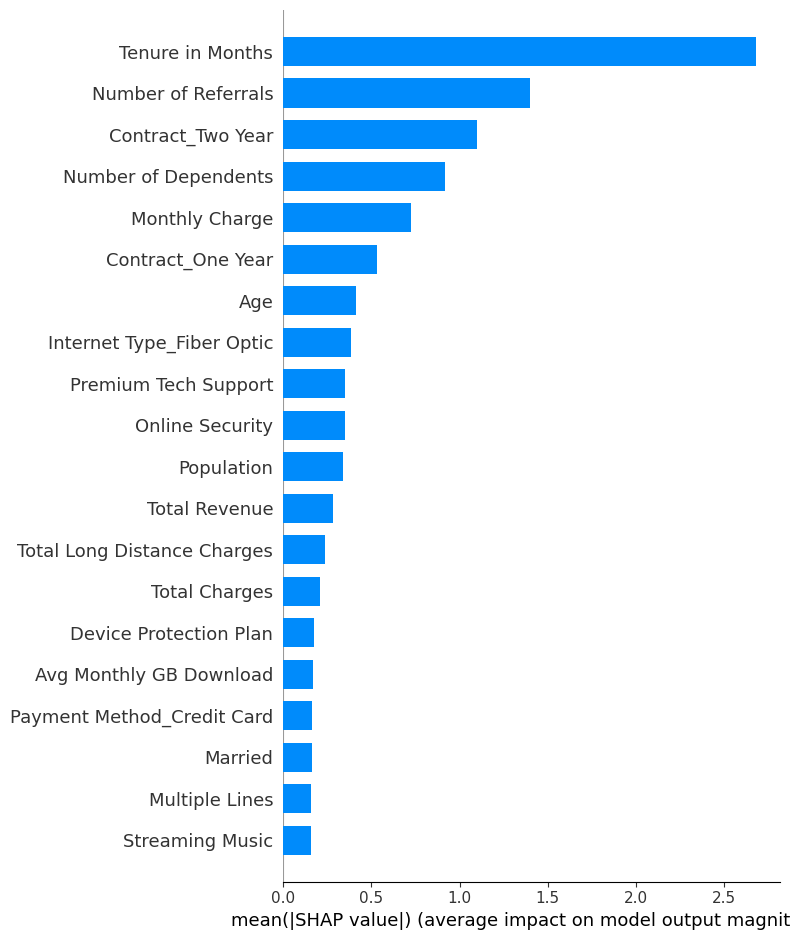

In [ ]:
# バイナリ分類の場合、shap_valuesはリストになっていることがあるので、クラス1のSHAP値を取得
shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# SHAP summary plot (bar plot)
shap.summary_plot(shap_values_class1, X_test, plot_type="bar")